# Worksheet

[FORM](https://forms.gle/5HJGU3rPkzqkbHW59)

For this worksheet you'll have to first install [pygraphviz](https://pygraphviz.github.io/documentation/stable/install.html). Then run the following cell without modifying it.

In [3]:
import numpy as np
import matplotlib as mpl
from PIL import Image as im
import matplotlib.pyplot as plt
from tensorflow import keras
import keras as keras
from networkx import DiGraph, set_node_attributes
from networkx.drawing.nx_agraph import to_agraph
from matplotlib.colors import rgb2hex

COLORS = np.array(['purple', 'blue'])
cvals  = [0, .5, 1]
colors = ['purple', 'white', 'blue']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

def unique_index(layer, node):
    return str(layer) + "_" + str(node)

class DenseGraph():

    def __init__(self, model):
        self.model = model
        self._graph = self._make_digraph()
        self._graph_original_copy = self._graph.copy()
        self._int_models = self._get_int_models()

    def get_graph(self):
        return self._graph


    def set_graph(self, graph=DiGraph()):
        self._graph = graph
        self._graph_original_copy = self._graph.copy()
        return


    def _reset(self):
        self._graph = self._graph_original_copy.copy()


    def _make_digraph(self):
        graph = DiGraph(nodesep='1', ranksep='1')

        for l in range(len(self.model.layers)):
            layer = self.model.layers[l]

            if type(layer) != keras.layers.Dense:
                raise ValueError("Unsupported Layer Type: %s Only Dense Layers are Supported", type(layer))

            if l == 0:
                for inp in range(layer._input_shape_arg[0]):
                    graph.add_node(
                        unique_index(l, inp),
                        shape="circle",
                        color="#3498db",
                        label=''
                    )
                inp += 1
            out = layer.units

            for h in range(out):
                if l == len(self.model.layers) - 1:
                    graph.add_node(
                        unique_index(l+1, h),
                        shape="circle",
                        color="#3498db",
                        label=''
                    )
                else:
                    graph.add_node(
                        unique_index(l+1, h),
                        shape="circle",
                        color="#2ecc71",
                        label=''
                    )
                for prev in range(inp):
                    graph.add_edge(
                        unique_index(l, prev),
                        unique_index(l + 1, h),
                        color="#B20000"
                    )
            inp = layer.units
        return graph



    def _get_int_models(self):
        """
        Creates a list of models where each model consists of all the layers
        (with matching weights and activations) in self.model up to a specified
        layer depth. This is important to get each node activation.
        """
        intermediate_models = []

        for l in range(len(self.model.layers)):
            int_model = keras.Sequential()
            inp = self.model.layers[0]._input_shape_arg[0]
            
            for prev_layer in range(l + 1):
                int_layer = self.model.layers[prev_layer]
                int_model.add(keras.layers.Dense(
                    int_layer.units,
                    input_dim=inp,
                    activation=int_layer.activation)
                )
                int_model.layers[prev_layer].set_weights(int_layer.get_weights())
                inp = int_layer.units
            int_model.compile(loss=self.model.loss)
            intermediate_models.append(int_model)

        return intermediate_models


    def _snap(self, filename):
        """
        Take snapshot image of the graph
        """
        out = to_agraph(self._graph)
        out.layout(prog='dot')
        out.draw(filename + '.png')
        return np.asarray(im.open(filename + '.png'))

    def animate_activations(self, X, filename='activations', duration=1000, x_color="#3498db", x_marker="o"):
        """
        Creates an animation of the graph activated by each data point
        """
        network_images = []

        predictions = [X]
        for i in range(len(self._int_models)):
            predictions.append(self._int_models[i].predict(X))
        predictions.append(self.model.predict(X))

        for i in range(len(X)):
            for l in range(len(self.model.layers)):
                if l == 0:
                    inp = self.model.layers[l]._input_shape_arg[0]
                else:
                    inp = self.model.layers[l-1].units
                for n in range(0, inp):
                    act = predictions[l][i][n]
                    index = unique_index(l, n)
                    if l == 0:
                        set_node_attributes(self._graph, {
                            index: {
                                'label' : " " + f"{act:.2f}" if act > 1 else " " + f"{act:.2f}".zfill(4) if act > 0 else f"{act:.2f}".zfill(4) if act > -1 else f"{act:.2f}"
                            }})
                    else:
                        # not used in the context of logistic regression
                        set_node_attributes(self._graph, {
                            index: {
                                'style': 'filled',
                                'color': str(rgb2hex(CMAP(act)))
                            }})

                for h in range(0, self.model.layers[l].units):
                    if l == len(self.model.layers) - 1:
                        act = predictions[l + 1][i][h]
                        index = unique_index(l + 1, h)

                        set_node_attributes(self._graph, {
                            index: {
                                'style': 'filled',
                                'color': str(rgb2hex(CMAP(act)))
                            }})

            network_images.append(self._snap(filename))
            self._reset()
        
        self._convert_gif(network_images, filename, duration)

        return
    
    def _convert_gif(self, imgs, filename, duration):
        stacked_images = []
        for img in imgs:
            stacked_images.append(im.fromarray(np.asarray(img)))

        stacked_images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=stacked_images[1:],
            loop=0,
            duration=duration
        )

        return

    def render(self, filename='graph'):
        """
        Creates a visualization of the graph for a Sequential Dense keras model
        """
        self._snap(filename)
        return

class LR():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename, func):
        h = .02
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        meshData = np.c_[xx.ravel(), yy.ravel()]

        fig, ax = plt.subplots(frameon=False)
        ax.scatter(X[:, 0], X[:, 1], color=COLORS[Y].tolist(), s=100, alpha=.9)
        Z = self.model.predict(func(meshData))
        Z = np.array([z[0] for z in Z]).reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4, cmap=CMAP)
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y, snap_freq=10, filename='learn', duration=1000, func=lambda x: x, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(func(X), Y, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename, func)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model


class LR3D():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename):

        weights, bias = self.model.layers[0].get_weights()
        w1, w2, w3 = weights[:, 0]
        b = bias[0]

        h = .5
        xx, yy = np.meshgrid(np.arange(-3.5, 3.5, h), np.arange(-3.5, 3.5, h))
        zz = -(w1 / w3) * xx - (w2 / w3) * yy - (b / w3)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(10, 80)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(0, 12)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=COLORS[Y].tolist(), s=30, alpha=.5)
        ax.plot_surface(xx, yy, zz, color='orange', alpha=0.3)
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y, snap_freq=10, filename='learn', duration=1000, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(X, Y, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model


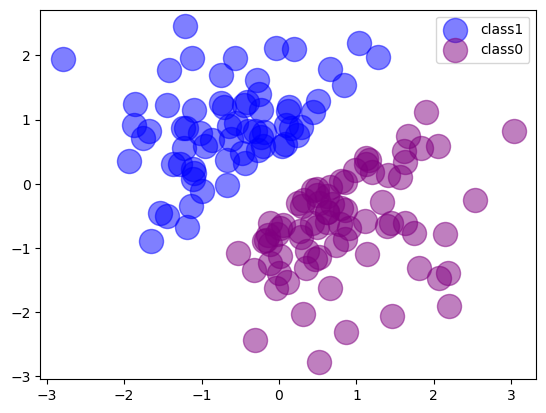

In [4]:
import sklearn.datasets as datasets

np.random.seed(1)

CENTERS = [[0, 0]]
DATA, _ = datasets.make_blobs(
        n_samples=200,
        centers=CENTERS,
        cluster_std=1,
        random_state=1
    )
w1 = 1 
w2 = -1
b = 0

X = np.array(list(filter(lambda x : w1 * x[0] + w2 * x[1] + b < -.5 or w1 * x[0] + w2 * x[1] + b > .5, DATA)))
Y = np.array([0 if w1 * x[0] + w2 * x[1] + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(X, Y, 10, 'lr', 100, epochs=200)


Epoch 1/10


/Users/liuruichen/anaconda3/envs/GRAPHICS_2024/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2904  
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.2851
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.2797
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2903 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2798 
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.2921
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.2844
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.2885
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.2720
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2849 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 279us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.2797
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.2764
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.2785
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.2766
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 

<Sequential name=sequential, built=True>

In [7]:
obj = DenseGraph(model)
obj.render('lr_graph')
obj.animate_activations(X[Y==0], 'lr_graph_activations', duration=100)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


## Non-Linearly Separable

In [ ]:
w1 = 1 
w2 = -1
b = 0

X = np.array(list(filter(lambda x : w1 * x[0]**2 + w2 * x[1]**2 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

Find new features X1 and X2 that make the data linearly separable. Animate the learned decision boundary throughout gradient descent in that feature space.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

X_transformed = np.array([[abs(x[0]), abs(x[1])] for x in X])

class1 = X_transformed[Y==1]
class0 = X_transformed[Y==0]

lr = LR(model)
lr.animate_learning(X, Y, 10, 'lr_transformed', 100, lambda x: x**2, epochs=500)

Animate the learned decision boundary throughout gradient descent in the original space.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = DenseGraph(model)
obj.render('lr_transformed_graph')
obj.animate_activations(X_transformed[Y==0], 'lr_transformed_graph_activations', duration=100)

## Higher Dimension

In [ ]:
w1 = -1 
w2 = -1
b = 1

X = np.array(list(filter(lambda x : w1 * x[0]**2 + w2 * x[1]**2 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

Add a new feature to X to make the data linearly separable in 3D

In [ ]:
X = np.column_stack((X, np.array([x[0]**2 + x[1]**2 for x in X])))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
class1 = X[Y==1]
class0 = X[Y==0]
ax.view_init(5, 80)
ax.scatter(class1[:,0], class1[:,1], class1[:,2], color=COLORS[1], s=30, alpha=.5, label='class1')
ax.scatter(class0[:,0], class0[:,1], class0[:,2], color=COLORS[0], s=30, alpha=.5, label='class0')
ax.legend()
plt.show()

Animate the learning process through gradient descent in 3D.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=3, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

lr = LR3D(model)
lr.animate_learning(X, Y, 10, 'lr_3d', 100, epochs=500)

Come up with a new example of a complex decision boundary that either requires new features or additional features or both. Animate the learned decision boundary. Also animate the graph representation of the logistic regression model as you feed it points only from class0.

Submit both gifs in the form

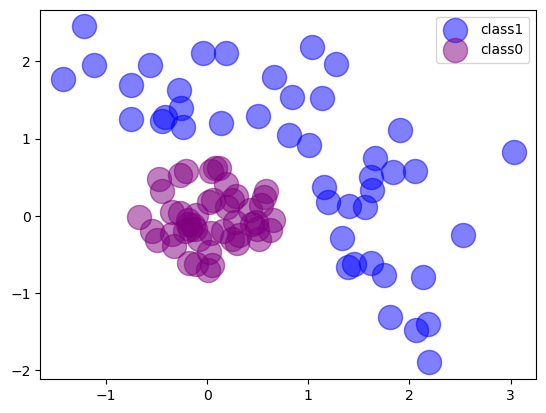

In [8]:
w1 = -1 
w2 = -1
b = 1

X = np.array(list(filter(lambda x : w1 * x[0]**3 + w2 * x[1]**3 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

lr = LR(model)
lr.animate_learning(X, Y, 10, 'lr_complex', 100, lambda x: x**2, epochs=500)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3183  
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3061 
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2813 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2570 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2841 
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3241 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2468 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2474 
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3379 
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2691 
2287/2287 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2928 
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2822 
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2098 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2616 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1

<Sequential name=sequential_3, built=True>

In [10]:
obj = DenseGraph(model)
obj.render('lr_graph')
obj.animate_activations(X[Y==0], 'lr_complex_activations', duration=100)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
